# CWT & STFT + CNN Model with Unicorn Hybrid Black dataset

In [386]:
import mne
import numpy as np
from mne.datasets import eegbci
import matplotlib.pyplot as plt
from mne.channels import make_standard_montage


raw_each = [0] * 9
num_subject = 1
for i in range(0,9):
    raw_each[i] = mne.io.read_raw_edf("C:\git\Senior_Thesis\DataSet\Convert_data\hand"+ str(i) +"_new.edf",preload = True)

# raw_edf = mne.concatenate_raws([raw_each[0],raw_each[1],raw_each[2],raw_each[4],raw_each[5],raw_each[6]])
# raw_edf = mne.concatenate_raws([raw_each[0],raw_each[1],raw_each[4],raw_each[3]])
# raw_edf = mne.concatenate_raws([raw_each[2],raw_each[5],raw_each[6],raw_each[7]])
raw_edf = mne.concatenate_raws([raw_each[8]])

# raw_edf = mne.io.read_raw_edf("C:\git\Senior_Thesis\DataSet\Convert_data\MI_execution.edf", preload=True)

eegbci.standardize(raw_edf)  # set channel names
montage = make_standard_montage("standard_1005")
raw_edf.set_montage(montage)

Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand0_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand1_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand2_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...


Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand3_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand4_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand5_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand6_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand7_n

<RawEDF | hand8_new.edf, 8 x 279250 (1117.0 s), ~17.1 MB, data loaded>

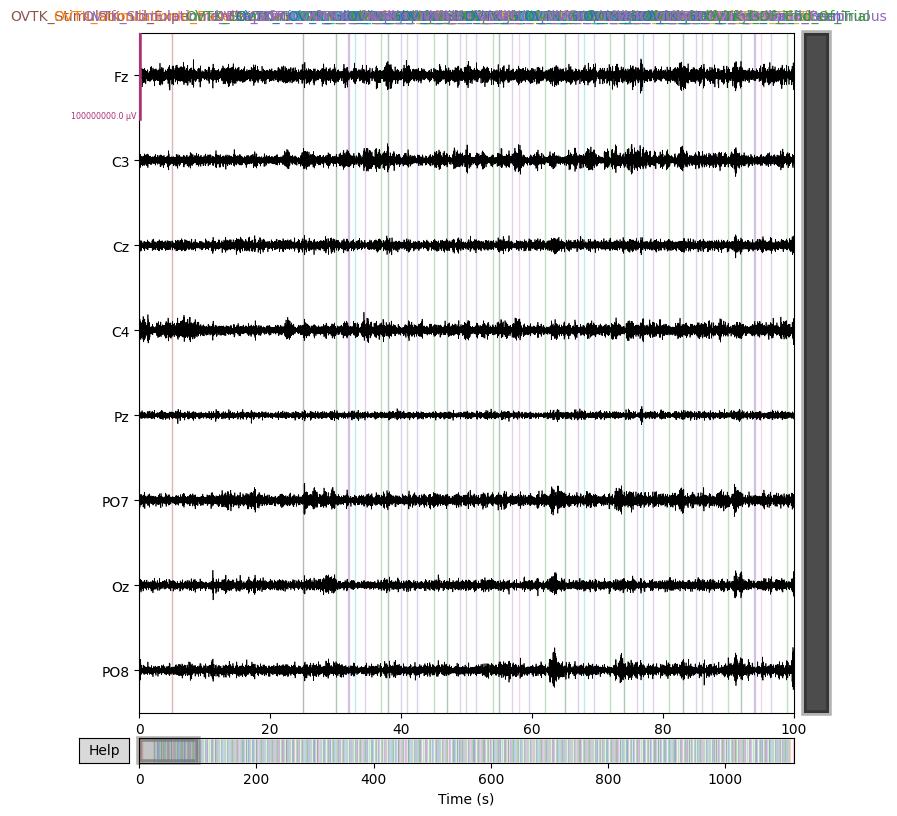

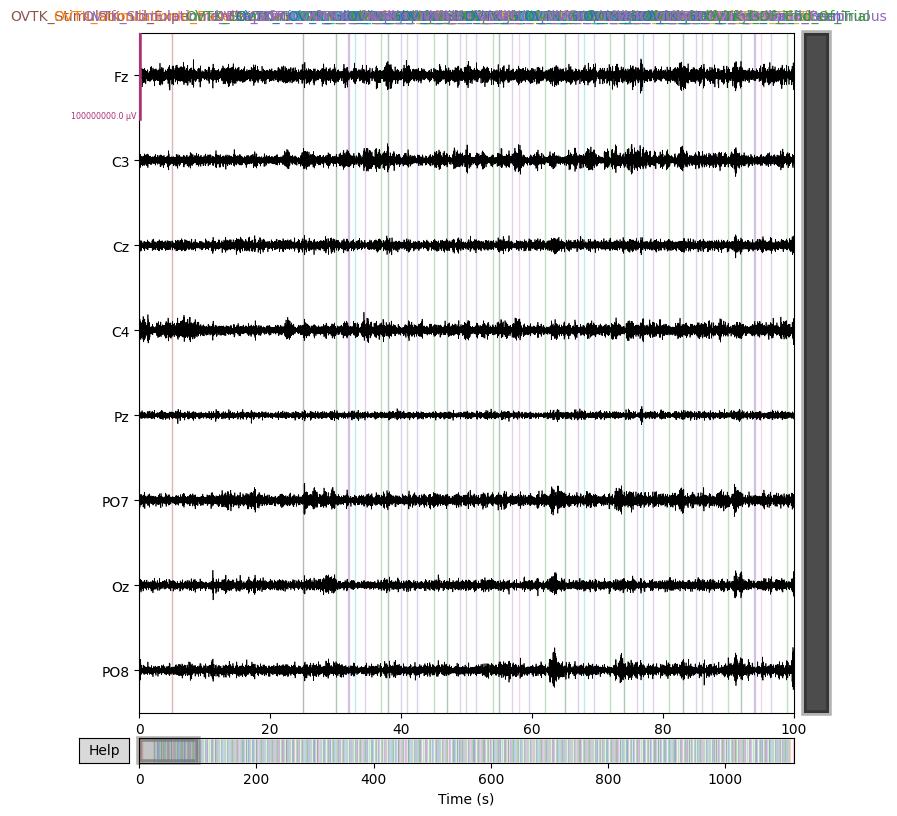

In [387]:
raw_edf.plot(scalings = 50, duration=100)

In [388]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization, Activation, Dropout
from keras.models import Sequential
from keras.callbacks import History,ModelCheckpoint
from keras.utils import plot_model
history = History()
import pywt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mne.decoding import CSP
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit,StratifiedKFold ,cross_val_score, cross_val_predict
from ssqueezepy import ssq_cwt, ssq_stft
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [389]:
# eeg1 = raw_edf.copy().set_eeg_reference(ref_channels="average")

# eeg1= eeg1.pick(["Fz","C3", "Cz", "C4","Pz",'PO7','PO8'])

eeg1= raw_edf.pick(["Fz","C3", "Cz", "C4","Pz",'PO7','PO8'])

events, event_dict = mne.events_from_annotations(eeg1)
combine_epochs = mne.Epochs(eeg1, events, 
        tmin= -1.0,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 3.0,    # final timestamp (10 means set epoch duration 10 second)
        event_id=event_dict,
        preload = True,
        event_repeated='drop',
        baseline=(-0.2, 0)
    )
combine_epochs = combine_epochs.copy().crop(tmin=0.0, tmax=1.0)
# combine_epochs = combine_epochs.copy().filter(l_freq=6.0, h_freq=32.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'})

nonim_epochs2 = mne.Epochs(eeg1, events, 
        tmin= -3.0,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 1.0,    # final timestamp (10 means set epoch duration 10 second)
        event_id=event_dict,
        preload = True,
        event_repeated='drop',
        baseline=(-2.2, 0)
    )
nonim_epochs2 = nonim_epochs2.copy().crop(tmin=-1.0, tmax=0.0)
# nonim_epochs2 = nonim_epochs2.copy().filter(l_freq=6.0, h_freq=32.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'})

component_num = 7

Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Incorrect', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_GDF_Tongue', 'OVTK_GDF_Up', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_Train']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
612 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 612 events and 1001 original time points ...
2 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
612 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded 

In [390]:
print(combine_epochs[0].get_data().max())
combine_epochs[0].get_data()

14.291029767449514


array([[[-2.98413619e+00, -4.58073020e+00, -6.57899898e+00, ...,
         -4.80893536e+00, -3.36223255e+00, -1.92647686e+00],
        [-1.15384125e+00,  3.92701209e-01,  1.47108517e+00, ...,
         -2.57819140e+00, -2.00329865e+00, -1.19506275e+00],
        [-5.40270122e-02,  5.30784985e-01,  2.43278729e-03, ...,
         -2.11515821e+00, -3.57335451e+00, -4.26760094e+00],
        ...,
        [-2.01853034e+00, -3.00896941e+00, -2.94291424e+00, ...,
          2.34616249e+00,  1.09223413e-01, -1.85067249e+00],
        [-1.40567709e+00, -1.30877776e+00, -1.02327864e-01, ...,
          5.14194906e+00,  5.34852565e+00,  4.67874897e+00],
        [ 3.05539260e+00,  3.00466981e+00,  2.51957549e+00, ...,
          5.46920067e-01,  1.38154052e+00,  2.18849400e+00]]])

In [391]:
combine_epochs

Number of events,610
Events,OVTK_GDF_Cross_On_Screen: 7OVTK_GDF_End_Of_Session: 1OVTK_GDF_End_Of_Trial: 120OVTK_GDF_Feedback_Continuous: 120OVTK_GDF_Left: 30OVTK_GDF_Right: 30OVTK_GDF_Start_Of_Trial: 120OVTK_GDF_Tongue: 30OVTK_GDF_Up: 30OVTK_StimulationId_BaselineStart: 1OVTK_StimulationId_BaselineStop: 1OVTK_StimulationId_Beep: 120OVTK_StimulationId_ExperimentStart: 0OVTK_StimulationId_Train: 0
Time range,0.000 – 1.000 s
Baseline,-0.200 – 0.000 s


In [392]:
nonim_epochs2

Number of events,611
Events,OVTK_GDF_Cross_On_Screen: 7OVTK_GDF_End_Of_Session: 1OVTK_GDF_End_Of_Trial: 120OVTK_GDF_Feedback_Continuous: 120OVTK_GDF_Left: 30OVTK_GDF_Right: 30OVTK_GDF_Start_Of_Trial: 120OVTK_GDF_Tongue: 30OVTK_GDF_Up: 30OVTK_StimulationId_BaselineStart: 1OVTK_StimulationId_BaselineStop: 1OVTK_StimulationId_Beep: 120OVTK_StimulationId_ExperimentStart: 0OVTK_StimulationId_Train: 1
Time range,-1.000 – 0.000 s
Baseline,-2.200 – 0.000 s


In [393]:
combine_epochs.event_id

{'OVTK_GDF_Cross_On_Screen': 1,
 'OVTK_GDF_End_Of_Session': 2,
 'OVTK_GDF_End_Of_Trial': 3,
 'OVTK_GDF_Feedback_Continuous': 4,
 'OVTK_GDF_Left': 6,
 'OVTK_GDF_Right': 7,
 'OVTK_GDF_Start_Of_Trial': 8,
 'OVTK_GDF_Tongue': 9,
 'OVTK_GDF_Up': 10,
 'OVTK_StimulationId_BaselineStart': 11,
 'OVTK_StimulationId_BaselineStop': 12,
 'OVTK_StimulationId_Beep': 13,
 'OVTK_StimulationId_ExperimentStart': 14,
 'OVTK_StimulationId_Train': 15}

# CSP -> CWT -> CNN

In [394]:
class_left = combine_epochs.event_id['OVTK_GDF_Left']
class_right = combine_epochs.event_id['OVTK_GDF_Right']
class_non = combine_epochs.event_id['OVTK_GDF_Tongue']
class_up = combine_epochs.event_id['OVTK_GDF_Up']

################ 3 Classes #######################
labels = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].events[:,2]
for i in range(0,len(labels)):
    if labels[i] == class_left:
        labels[i] = 1
    elif labels[i] == class_right:
        labels[i] = 1
    elif labels[i] == class_non:
        labels[i] = 2
    else:
        labels[i] = 1
        
train_data1 = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].get_data()
train_data2 = nonim_epochs2['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].get_data()
train_data = np.concatenate((train_data1, train_data2), axis=0)
# train_data = train_data1

for i in range(0,num_subject):
    labels = np.concatenate((labels,np.full((120,), 2)), axis = 0)

In [395]:
train_data.shape

(240, 7, 251)

In [396]:
labels

array([2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1,
       2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

train csp

In [397]:
# csp = CSP(n_components=component_num, reg=None, log=None, transform_into='csp_space')
# csp.fit(train_data, labels)

# with open('trained_csp_newsess_try_model.pkl', 'wb') as file:
#     pickle.dump(csp, file)

Computing rank from data with rank=None
    Using tolerance 1.5 (2.2e-16 eps * 7 dim * 9.7e+14  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9 (2.2e-16 eps * 7 dim * 1.3e+15  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.


load csp

In [398]:
with open('trained_csp_newsess_try_model.pkl', 'rb') as file:
    trained_csp = pickle.load(file)

new_data = trained_csp.transform(train_data)
print(new_data.shape)

(240, 7, 251)


try csp+lda trined model

In [406]:
csp2 = CSP(n_components=7, reg=None, log=None)
csp2.fit(train_data, labels)
with open('trained_csp2_model.pkl', 'wb') as file:
    pickle.dump(csp2, file)

with open('trained_csp2_model.pkl', 'rb') as file:
    trained_csp2 = pickle.load(file)
new_data2 = trained_csp2.transform(train_data)

lda2 = LinearDiscriminantAnalysis()
lda2.fit(new_data2, labels)
with open('trained_lda_model.pkl', 'wb') as file:
    pickle.dump(lda2, file)

with open('trained_lda_model.pkl', 'rb') as file:
    trained_lda = pickle.load(file)

    
score = cross_val_score(trained_lda,new_data2, labels, cv= 10)
lda_predicted = cross_val_predict(trained_lda, new_data2, labels, cv=10)
conf_matrix = confusion_matrix(labels, lda_predicted)
print("LDA only classification scores", np.mean(score))
print(conf_matrix)

# score = trained_lda.score(new_data2, labels)
# lda_predicted = trained_lda.predict(new_data2)
# conf_matrix = confusion_matrix(labels, lda_predicted)
# print("LDA only classification scores", score)
# print(conf_matrix)


Computing rank from data with rank=None
    Using tolerance 1.5 (2.2e-16 eps * 7 dim * 9.7e+14  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9 (2.2e-16 eps * 7 dim * 1.3e+15  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
LDA only classification scores 0.8291666666666668
[[ 69  21]
 [ 20 130]]


In [400]:
np.shape(new_data)

(240, 7, 251)

CWT

In [401]:
FB = 1
train_cwt = np.ndarray(shape=(new_data.shape[0], new_data.shape[2], component_num*FB))
for jj in range(0, new_data.shape[0]):
    train_cwt[jj] = new_data[jj].T
print(np.shape(train_cwt))

scales = range(1,31)

waveletname = 'morl'
train_size = len(labels)
train_data_cwt = np.ndarray(shape=(train_size, len(scales), new_data.shape[2], component_num*FB))

for ii in range(0,train_size):
    if ii % 40 == 0:
        print(ii)
    for jj in range(0,component_num*FB):
        signal = train_cwt[ii, :, jj]
        coeff, _ = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:new_data.shape[2]]  #crop 227 sample for each channel
        train_data_cwt[ii, :, :, jj] = coeff_
print(np.shape(train_data_cwt))

train_cwt_stack = np.ndarray(shape=(train_size, len(scales)*component_num*FB, new_data.shape[2]))

# train_cwt_stack = np.ndarray(shape=(train_size , new_data.shape[2], len(scales)*component_num*FB))


for jj in range(0,train_data_cwt.shape[0]):
    # train_cwt_stack[jj] = np.concatenate(train_data_cwt[jj], axis = 1)
    
    train_cwt_stack[jj] = np.vstack((train_data_cwt[jj,:,:,0], train_data_cwt[jj,:,:,1], train_data_cwt[jj,:,:,2], train_data_cwt[jj,:,:,3], train_data_cwt[jj,:,:,4], train_data_cwt[jj,:,:,5], train_data_cwt[jj,:,:,6]))
    # train_cwt_stack[jj] = np.vstack((train_data_cwt[jj,:,:,0], train_data_cwt[jj,:,:,1], train_data_cwt[jj,:,:,2]))
print(np.shape(train_cwt_stack))

(240, 251, 7)
0


40
80
120
160
200
(240, 30, 251, 7)
(240, 210, 251)


Try scaler

In [402]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# reshaped_data = train_cwt_stack.reshape((train_cwt_stack.shape[0], -1))
# scaled_data = scaler.fit_transform(reshaped_data)
# scaled_data_3d = scaled_data.reshape(train_cwt_stack.shape)
# print(scaled_data_3d.shape)

In [403]:
# train_cwt_stack = scaled_data_3d

x_train, x_test, y_train, y_test = train_test_split(train_cwt_stack, labels, test_size=0.3, random_state=42)

num_classes = len(np.unique(labels))
lowest = np.min(y_train)
batch_size = 1
epochs = 15
print(np.shape(x_train), np.shape(x_test), np.shape(y_train), np.shape(y_test))

y_train = keras.utils.to_categorical(y_train-lowest, num_classes)
y_test = keras.utils.to_categorical(y_test-lowest, num_classes)

(168, 210, 251) (72, 210, 251) (168,) (72,)


# Purposed CNN Model

In [404]:
# # Define the CNN model
# model = Sequential()

# # Convolutional Layer 1 with 32 filters of kernel size 3x3
# model.add(Conv2D(32, (3, 3), input_shape=(train_cwt_stack.shape[1], train_cwt_stack.shape[2], 1), activation='relu'))
# # model.add(BatchNormalization())
# # Max-Pooling Layer 1 with pool size 2x2
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Convolutional Layer 2 with 64 filters of kernel size 3x3
# model.add(Conv2D(64, (3, 3), activation='relu'))
# # model.add(BatchNormalization())
# # model.add(Dropout(0.5)) 

# # Max-Pooling Layer 2 with pool size 2x2
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Flatten the output from the previous layer
# model.add(Flatten())

# # Output Layer with the desired number of output nodes (adjust as needed)
# model.add(Dense(num_classes, activation='softmax'))

# model.compile(loss=keras.losses.categorical_crossentropy, 
#               optimizer=keras.optimizers.Adam(learning_rate= 0.0001), 
#               metrics=['accuracy'])

# model.summary()
# plot_model(model,to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# checkpoint = ModelCheckpoint("CNN_model_newsess_try_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# model.fit(x_train, y_train, batch_size=batch_size, 
#           epochs=epochs, verbose=1, 
#           validation_data=(x_test, y_test), 
#           callbacks=[history, checkpoint])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 208, 249, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 104, 124, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 102, 122, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 51, 61, 64)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 199104)            0         
                                                                 
 dense_4 (Dense)             (None, 2)                

C:\Users\pipo_\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


168/168 [==============================] - ETA: 0s - loss: 0.1378 - accuracy: 0.9464
Epoch 2: val_accuracy improved from 0.72222 to 0.86111, saving model to CNN_model_newsess_try_weights.h5
168/168 [==============================] - 8s 46ms/step - loss: 0.1378 - accuracy: 0.9464 - val_loss: 0.3240 - val_accuracy: 0.8611
Epoch 3/15
167/168 [============================>.] - ETA: 0s - loss: 0.0165 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.86111
168/168 [==============================] - 8s 45ms/step - loss: 0.0164 - accuracy: 1.0000 - val_loss: 0.5777 - val_accuracy: 0.7639
Epoch 4/15
168/168 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 1.0000
Epoch 4: val_accuracy improved from 0.86111 to 0.87500, saving model to CNN_model_newsess_try_weights.h5
168/168 [==============================] - 8s 47ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.4009 - val_accuracy: 0.8750
Epoch 5/15
168/168 [==============================] - ETA: 0s - lo

8/8 [==============================] - 1s 140ms/step


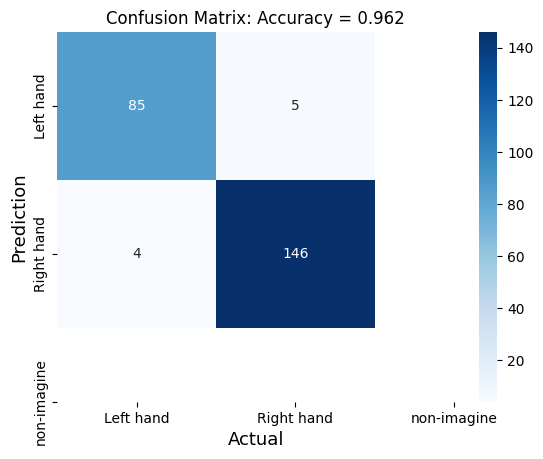

In [405]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
pretrained_model = load_model("CNN_model_newsess_try_weights.h5")

y_test = keras.utils.to_categorical(labels-lowest, num_classes)

loss, accuracy = pretrained_model.evaluate(train_cwt_stack, y_test)

y_pred = pretrained_model.predict(train_cwt_stack)
y_pred = np.argmax(y_pred, axis=1) 
y_true = np.argmax(y_test, axis=1)

confusion_mat = confusion_matrix(y_true, y_pred)

# class_names = ['Left hand', 'Right hand',  'Non-imagine', 'Feet']

# class_names = ['Right hand','Non-imagine']

# class_names = ['Imagine','Non-imagine']

class_names = ['Left hand', 'Right hand', 'non-imagine']

# class_names = ['Left hand', 'Right hand', 'Up']

sns.heatmap(confusion_mat, 
            annot=True,
            fmt='d', 
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title("Confusion Matrix: Accuracy = "+ str(round(accuracy,3)))
plt.show()